# Analyzing Age Distribution and Motor Vehicles in German Constituencies

Imports:

In [1]:
import geopandas as gpd
import folium
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from matplotlib_venn import venn2

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# user written modules
import dataproject


# Read and Clean Age Distribution Data

In [2]:
# A. import Data on Age Distribution in German counties from federal statistics department
dfA = pd.read_csv('dataX.csv', sep = ';')

# B. start cleaning by removing all rows whoch are empty
dfA.replace('-',None, inplace = True)
dfA.dropna(subset=['unter 3 Jahre'], inplace = True)

# C. convert to numeric
dfA = dfA.apply(pd.to_numeric, errors = 'ignore')

# D. Set age ranges
age_ranges = [
    ('20 bis unter 25 Jahre', '25 bis unter 30 Jahre'),
    ('30 bis unter 35 Jahre', '35 bis unter 40 Jahre'),
    ('40 bis unter 45 Jahre', '45 bis unter 50 Jahre'),
    ('50 bis unter 55 Jahre', '55 bis unter 60 Jahre')
]

# loop over the age ranges and add them together
for age_range in age_ranges:
    col1, col2 = age_range
    lower_bound = int(col1.split()[0])
    upper_bound = int(col2.split()[0])
    new_col_name = f'{lower_bound}-{upper_bound}'
    dfA[new_col_name] = dfA[col1] + dfA[col2]

# drop irrelevant age ranges
dfA.drop(['unter 3 Jahre', '3 bis unter 6 Jahre', '6 bis unter 10 Jahre', '10 bis unter 15 Jahre', '15 bis unter 18 Jahre', '18 bis unter 20 Jahre', '20 bis unter 25 Jahre', '25 bis unter 30 Jahre', '30 bis unter 35 Jahre', '35 bis unter 40 Jahre', '40 bis unter 45 Jahre', '45 bis unter 50 Jahre', '50 bis unter 55 Jahre', '55 bis unter 60 Jahre', '60 bis unter 65 Jahre'], axis=1, inplace=True)

# E. remame the columns 
dfA_final = dfA.rename(columns = {'65 bis unter 75 Jahre':'65 to under 75 years', 'Landkreis':'County', 'Datum':'Date','75 Jahre und mehr':'75 years and older', 'Insgesamt':'Total', '20-25':'20 to under 30 years', '30-35':'30 to under 40 years', '40-45':'40 to under 50 years', '50-55':'50 to under 60 years' })

# F. ratios
# add column to construct a ratio between >65year olds in comparison to whole population
dfA_final["65+years/Total"] = (dfA_final["65 to under 75 years"] + dfA_final["75 years and older"]) / dfA_final["Total"]

# age groups
age_group =[
    ('20 to under 30 years'),
    ('30 to under 40 years'), 
    ('40 to under 50 years'), 
    ('50 to under 60 years'), 
]

# calculate ratios
for age_group in age_group:
    dfA_final[f"{age_group}/Total"] = dfA_final[age_group] / dfA_final["Total"]

# G. new column order 
new_column_order = ['Date', 'B-code', 'County', '20 to under 30 years', '30 to under 40 years', '40 to under 50 years', '50 to under 60 years', '65 to under 75 years', '75 years and older','20 to under 30 years/Total','30 to under 40 years/Total', '40 to under 50 years/Total', '50 to under 60 years/Total', '65+years/Total', 'Total']
dfA_final = dfA_final.reindex(columns=new_column_order)

# H. display the modified DataFrame
dfA_final.head()


,Date,B-code,County,20 to under 30 years,30 to under 40 years,40 to under 50 years,50 to under 60 years,65 to under 75 years,75 years and older,20 to under 30 years/Total,30 to under 40 years/Total,40 to under 50 years/Total,50 to under 60 years/Total,65+years/Total,Total
0,31.12.2021,1001,"Flensburg, kreisfreie Stadt",16718,11598,9832,12658,8861,9532,0.183486,0.127292,0.107910,0.138926,0.201870,91113
1,31.12.2021,1002,"Kiel, kreisfreie Stadt",44571,37198,27421,34354,22414,24416,0.181004,0.151062,0.111357,0.139513,0.190178,246243
2,31.12.2021,1003,"L�beck, kreisfreie Stadt",28215,27609,24774,33512,23374,27556,0.130458,0.127656,0.114548,0.154949,0.235485,216277
3,31.12.2021,1004,"Neum�nster, kreisfreie Stadt",9526,10015,9131,12280,8583,9749,0.119830,0.125981,0.114861,0.154473,0.230603,79496
4,31.12.2021,1051,"Dithmarschen, Landkreis",14099,14183,14565,22702,16993,17130,0.105241,0.105868,0.108719,0.169457,0.254708,133969


We use ratios since contituencies differ significantly in population. Thus, population-dense counties might skew our results if we use absolute values.

# Read and Clean Motor Vehicle Data

In [10]:


# A. Import the vehicles data set
dfK = pd.read_csv('dataY.csv', sep = ';')


# B. First Preparation of the raw data set
# Drop empty columns
dfK.drop(['Leichtkraftraeder', 'Gewoehnliche Zugmaschinen'], axis = 1, inplace=True)

# Drop empty raws
dfK.replace('-',None, inplace = True)
dfK.dropna(subset=['Kfz'], inplace = True)


# C. create a copy of dfK for next step of manipulations
transport = dfK.copy()


# D. transform strings to numbers
transport = transport.apply(pd.to_numeric, errors = 'ignore')


# E. creating sums of existing columns
# creating Zweiraeder as sum of Kraftraeder and Motorraeder
transport['Zweiraeder'] = transport[['Kraftraeder', 'Motorraeder']].sum(axis=1)

# creating Pkw1 as sum of Pkw mit Ottomotor and Dieselmotor
transport['Pkw1'] = transport[['Pkw mit Ottomotor', 'Pkw mit Dieselmotor']].sum(axis=1)

# creating KFZ as sum of ZWeiraeder, Pkw1 and Wohnmobile 
transport['KFZ'] = transport[['Zweiraeder', 'Pkw1', 'Wohnmobile']].sum(axis=1)

# F. dropping useless columns
# Create list of columns, that we want to keep
keep_columns = ['Datum', ' B-code', ' Stadt', 'Pkw mit Ottomotor', 'Pkw mit Dieselmotor', 'Pkw1', 'Wohnmobile', 'Zweiraeder', 'KFZ'] 

# delete every other column
transport = transport.loc[:, keep_columns]


# G. rename the columns
transport.rename(columns = {'Datum':'date', ' B-code':'B-code', ' Stadt':'County', 'Pkw mit Ottomotor':'cars petrol', 'Pkw mit Dieselmotor': 'cars diesel', 'Pkw1':'cars', 'Wohnmobile':'campers', 'Zweiraeder':'two-wheelers', 'KFZ':'vehicles'}, inplace=True)


# H. creating new ratios
# create the lists for the ratios
numerator_columns = ['cars petrol', 'cars diesel', 'campers', 'two-wheelers']
denominator_columns = ['vehicles', 'vehicles', 'vehicles', 'vehicles']
 
# create the if loop to create the ratios
for i in range(len(numerator_columns)):
    ratio = transport[numerator_columns[i]] / transport[denominator_columns[i]]
    transport[numerator_columns[i] + '/' + denominator_columns[i]] = ratio


# I. show the final dataFrame
transport.head()



,date,B-code,County,cars petrol,cars diesel,cars,campers,two-wheelers,vehicles,cars petrol/vehicles,cars diesel/vehicles,campers/vehicles,two-wheelers/vehicles
0,01.01.2022,1001,"Flensburg, kreisfreie Stadt",26809,16230,43039,1489,5826,50354,0.532411,0.322318,0.029571,0.115701
1,01.01.2022,1002,"Kiel, kreisfreie Stadt",71089,35234,106323,3650,16458,126431,0.562275,0.278682,0.028870,0.130174
2,01.01.2022,1003,"L�beck, kreisfreie Stadt",66824,30127,96951,2359,16839,116149,0.575330,0.259382,0.020310,0.144978
3,01.01.2022,1004,"Neum�nster, kreisfreie Stadt",26943,14163,41106,864,6845,48815,0.551941,0.290136,0.017699,0.140223
4,01.01.2022,1051,"Dithmarschen, Landkreis",48386,32319,80705,2184,15976,98865,0.489415,0.326900,0.022091,0.161594


# Merge two datasets

In [4]:
#merge age and motor vehicles datasets
merged = pd.merge(dfA_final, transport, on='B-code')
merged.head()

,Date,B-code,County_x,20 to under 30 years,30 to under 40 years,40 to under 50 years,50 to under 60 years,65 to under 75 years,75 years and older,20 to under 30 years/Total,...,cars petrol,cars diesel,cars,campers,two-wheelers,vehicles,cars petrol/vehicles,cars diesel/vehicles,campers/vehicles,two-wheelers/vehicles
0,31.12.2021,1001,"Flensburg, kreisfreie Stadt",16718,11598,9832,12658,8861,9532,0.183486,...,26809,16230,43039,1489,5826,50354,0.532411,0.322318,0.029571,0.115701
1,31.12.2021,1002,"Kiel, kreisfreie Stadt",44571,37198,27421,34354,22414,24416,0.181004,...,71089,35234,106323,3650,16458,126431,0.562275,0.278682,0.028870,0.130174
2,31.12.2021,1003,"L�beck, kreisfreie Stadt",28215,27609,24774,33512,23374,27556,0.130458,...,66824,30127,96951,2359,16839,116149,0.575330,0.259382,0.020310,0.144978
3,31.12.2021,1004,"Neum�nster, kreisfreie Stadt",9526,10015,9131,12280,8583,9749,0.119830,...,26943,14163,41106,864,6845,48815,0.551941,0.290136,0.017699,0.140223
4,31.12.2021,1051,"Dithmarschen, Landkreis",14099,14183,14565,22702,16993,17130,0.105241,...,48386,32319,80705,2184,15976,98865,0.489415,0.326900,0.022091,0.161594


# Convert to Geodataframe

In [9]:
#import geodata of German constituencies to map
dfgeo = gpd.read_file("DE-counties.geojson")

#rename AGS to B-code to prepare for merging
dfgeo.rename(columns={"AGS":"B-code"}, inplace=True)

#merge DE counties geofile with variables

#make sure targeted variable has the same type
dfgeo['B-code']=dfgeo['B-code'].astype(int)
merged['B-code']=merged['B-code'].astype(int)

#merge the datasets
merged1 = pd.merge(merged, dfgeo, on='B-code', how="left")

#drop duplicates 
merged1.drop_duplicates(subset=['B-code'], inplace=True)

#create geodataframe to prepare for mapping
geomerged = gpd.GeoDataFrame(merged1)
geomerged.head()

# Interactive slider for Age Distribution

In [13]:
#interactive graph for different age distribution

#set columns to ratios of ages
dataproject.min1 = 9
dataproject.max1 = 13

dataproject.dfK_new1 = transport 

dataproject.merged2 = merged1

dataproject.interactive_plot1(True)

interactive(children=(IntSlider(value=9, description='Column:', max=13, min=9), Output()), _dom_classes=('widg…

The graph above shows the ratios for different age groups to the total population in Germany constituencies.
Generally, it can be observed that the population seems to be older in the east of the country. Additionally, population in urban areas seems to be comparatively younger than population in rural areas.

# Interactive Slider for Motor Vehicles

In [14]:
#interactive graph for the distribution of motor vehicles

#set columns for ages
dataproject.min1 = 23
dataproject.max1 = 26

dataproject.dfK_new1 = transport 

dataproject.merged2 = merged1

dataproject.interactive_plot1(True)

interactive(children=(IntSlider(value=23, description='Column:', max=26, min=23), Output()), _dom_classes=('wi…

The graph above shows the ratios of different motor vehicles to the total amount of vehicles. For example, campers seem to be most prevalent in the Northern and Southern part of the country, coinciding with popular German vacation spots. There seem to be more two-wheeled vehicles in the South of the country. For petrol-powered vehicles a strong concentration can be observed in the Eastern and Western part of the country, with diesel-powered vehicles being more common in the North and South.

# Analysis

The following part will look at different combinations between age and vehicle distribution. This might hint at possible correlations, but is not sufficient to prove causal relationships.

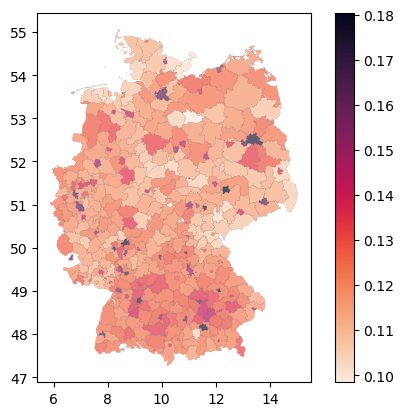

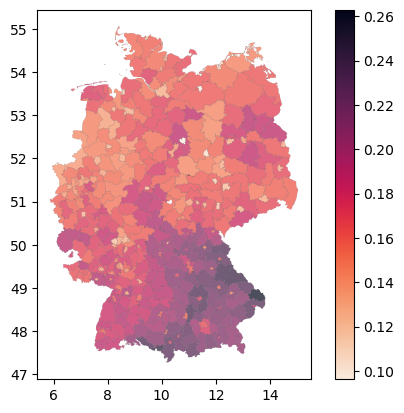

In [17]:
#plot young population and two-wheeled vehicles

dataproject.ratio = "30 to under 40 years/Total"

dataproject.plot(True)

dataproject.ratio = "two-wheelers/vehicles"

dataproject.plot(True)

TypeError: plot() missing 1 required positional argument: 'self'

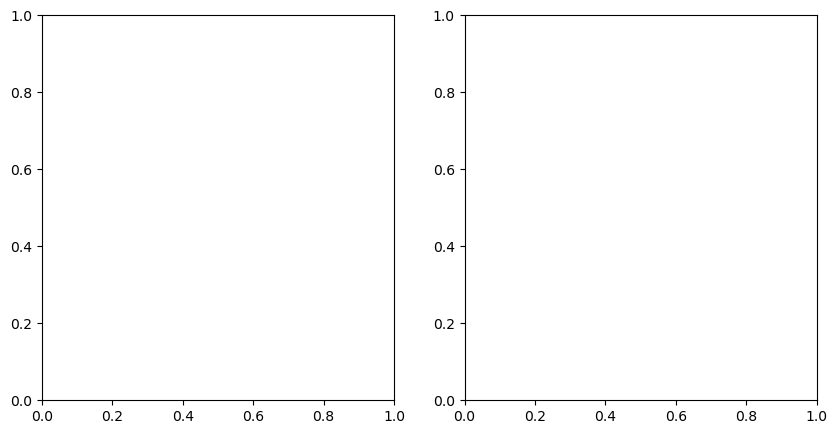

In [27]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# plot the first graph on the left axis object
dataproject.ratio = "30 to under 40 years/Total"
dataproject.plot(ax=axs[0])
axs[0].set_title("Ratio of 30 to under 40 years to Total")

# plot the second graph on the right axis object
dataproject.ratio = "two-wheelers/vehicles"
dataproject.plot(ax=axs[1])
axs[1].set_title("Ratio of Two-wheelers to Vehicles")

# adjust the layout and spacing between subplots
plt.tight_layout()

# show the plots
plt.show()

In this example, we show that younger counties generally seem to own less two-wheeled vehicles. This is espcially obvious in the cities, which have comparatively young population and a relatively low concentration of two-wheeled vehicles. This relationship might come as a surprise, as cities are often associated with a great number of two-wheeled vehicles.
There are several factors which might play a role in explaining this phenomenon. Firstly, bikes and other non-motorized vehicles are excluded from our data. Secondly, public transportation is a good substitute in an urban environment, especially 

# Conclusion

ADD CONCISE CONLUSION.